# TO DO

1) Add another check for the collision since now we are introducing a robot and not more a rigid material point moving in the plane

2) In the steer function add the trajectory controller taking in account the dynamics of the robot and the fact that the robot is controlled in velocity

3) Decied how to do the feedback

# CODE

In [ ]:
#!pip install seaborn

In [1]:
import numpy as np
import math
from env import *
from plotting import *
import copy
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline

## RRT + steer

In [2]:
class Node:
    def __init__(self, x, y):

        self.x = x
        self.xd = None
        self.xdd = None

        self.y = y
        self.yd = None
        self.ydd = None

        self.theta = None
        self.thetad = None
        self.thetadd = None

        self.parent = None
        self.cost = None

        self.commands = None
        self.conf = None


class RRT_STAR:
    def __init__(self, start, goal, env, step, prob_gs, n_iters):

        self.node_s = Node(start[0], start[1])
        self.node_g = Node(goal[0], goal[1])

        ##################### INITIAL CONDITION #################
        self.node_s.theta = theta
        self.node_s.xd = xd
        self.node_s.xdd = xdd
        self.node_s.yd = yd
        self.node_s.ydd = ydd
        self.node_s.thetad = thetad
        self.node_s.thetadd = thetadd
        self.node_s.conf = [(self.node_s.x, self.node_s.y)]
        self.node_g.conf = [(self.node_g.x, self.node_g.y)]

        #########################################################

        self.env = env
        self.n_iters = n_iters
        # CHECK IF START NODE AND GOAL NODE IN THE ENV......
        self.step = step
        self.prob_gs = prob_gs  # Empirical value
        self.utils = Utils()
        self.node_s.cost = 0
        self.Tree = [self.node_s]
        self.plotting = Plotting(self.node_s, self.node_g)
        # Empirical value
        self.radius = max(self.env.x_range[-1], self.env.y_range[-1])//20
        self.trav_map = np.clip(np.random.normal(3, 8, size=(50, 30)), 2, 100)

    def planning(self):
        # ax = sns.heatmap(self.trav_map.T, linewidth=0.5)
        # plt.show()
        for iter in range(self.n_iters):
            if iter % 500 == 0:
                print(iter)
            # print(iter)
            n_rand = self.sample()
            n_nearest, n_new = self.compute_NN(n_rand)

            if n_nearest.x == n_new.x and n_nearest.y == n_new.y:
                continue

            n_new, xd, xdd, yd, ydd, thetaf, thetad, thetadd, commands, conf = self.steer(
                n_nearest, n_new)

            if not self.utils.is_collision(n_nearest, n_new) and int(n_new.x) in range(0, self.env.x_range[-1]) and int(n_new.y) in range(0, self.env.y_range[-1]):
                # Assign to node velocity, acceleration and commands
                n_new.xd = xd
                n_new.xdd = xdd
                n_new.yd = yd
                n_new.ydd = ydd
                n_new.theta = thetaf
                n_new.thetad = thetad
                n_new.thetadd = thetadd
                n_new.commands = commands
                n_new.conf = conf

                N_near = self.compute_NN(n_new, near=True)
                n_min, cost_min = self.choose_parent(N_near, n_nearest, n_new)
                n_new.parent = n_min
                n_new.cost = cost_min
                # Insert Node
                self.Tree.append(n_new)
                self.rewire(N_near, n_min, n_new)
        path = [[self.node_g]]
        goal_state = self.get_goal_state()

        self.tot_path = self.compute_path(path, goal_state)

        self.plotting.animation(self.Tree, self.tot_path,
                                "rrt*, N = " + str(self.n_iters))

    def choose_parent(self, N_near, n_nearest, n_new):
        n_parent = n_nearest
        # Init. guess parent for sampled node
        cost_min = n_nearest.cost + self.compute_cost(n_nearest, n_new)

        # print('LEN: ', len(N_near))
        for n_near in N_near:
            # print('before_steer')
            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue
            n_new_tr, xd, xdd, yd, ydd, thetaf, thetad, thetadd, commands, conf = self.steer(
                n_near, n_new)
            # print('after_steer')

            if not self.utils.is_collision(n_near, n_new_tr) and int(n_new_tr.x) in range(0, self.env.x_range[-1]) and int(n_new_tr.y) in range(0, self.env.y_range[-1]):

                inter_cost = n_near.cost + \
                    self.compute_cost(n_near, n_new_tr)  # Intermediate cost
                if n_new_tr.cost != None:
                    if inter_cost < n_new.cost and inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost

                        n_new.xd = xd
                        n_new.xdd = xdd
                        n_new.yd = yd
                        n_new.ydd = ydd
                        n_new.theta = thetaf
                        n_new.thetad = thetad
                        n_new.thetadd = thetadd
                        n_new.commands = commands
                        n_new.conf = conf

                        n_new.x, n_new.y = n_new_tr.x, n_new_tr.y
                        n_new.x, n_new.y = n_new_tr.x, n_new_tr.y

                else:
                    if inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost

                        n_new.xd = xd
                        n_new.xdd = xdd
                        n_new.yd = yd
                        n_new.ydd = ydd
                        n_new.theta = thetaf
                        n_new.thetad = thetad
                        n_new.thetadd = thetadd
                        n_new.commands = commands
                        n_new.conf = conf

                        n_new.x, n_new.y = n_new_tr.x, n_new_tr.y
                        n_new.x, n_new.y = n_new_tr.x, n_new_tr.y
        # print('Sono uscito da Choose parent...')

        return n_parent, cost_min

    def rewire(self, N_near, n_parent, n_new):
        # print("LEN: ", len(N_near))
        for n_near in N_near:
            # print('kawabonga')
            if n_near.x == n_parent.x and n_near.y == n_parent.y:
                continue

            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue

            z_near, xd, xdd, yd, ydd, thetaf, thetad, thetadd, commands, conf = self.steer(
                n_near, n_new)

            if not self.utils.is_collision(z_near, n_new) and int(z_near.x) in range(0, self.env.x_range[-1]) and int(z_near.y) in range(0, self.env.y_range[-1]):

                if n_new.cost + self.compute_cost(z_near, n_new) < n_near.cost:

                    n_near_old_idx = self.Tree.index(n_near)
                    z_near.parent = n_new
                    z_near.cost = n_new.cost + self.compute_cost(z_near, n_new)
                    self.Tree[n_near_old_idx] = z_near

                    z_near.xd = xd
                    z_near.xdd = xdd
                    z_near.yd = yd
                    z_near.ydd = ydd
                    z_near.theta = thetaf
                    z_near.thetad = thetad
                    z_near.thetadd = thetadd
                    z_near.commands = commands
                    z_near.conf = conf

        # print('sono uscito')
        return

    def compute_NN(self, n_curr, near=False):

        # CHECK COLLISION
        dist_list = np.array([self.compute_dist(n_curr, n_tree)
                             for n_tree in self.Tree])

        if not near:  # Nearest

            n_nearest = self.Tree[np.argmin(dist_list)]
            dist = min(np.min(dist_list), self.step)
            theta = math.atan2(n_curr.y-n_nearest.y, n_curr.x - n_nearest.x)
            n_new = Node(n_nearest.x + dist*math.cos(theta),
                         n_nearest.y + dist*math.sin(theta))

            return n_nearest, n_new
        else:        # Near
            node_list = [self.Tree[idx] for idx in range(
                len(dist_list)) if dist_list[idx] < self.radius]

            return node_list

    def sample(self):
        ''' Sample function RRT*, sample the goal node with a low probability '''
        if np.random.random() > self.prob_gs:
            x_new = np.random.uniform(self.env.x_range[-1])
            y_new = np.random.uniform(self.env.y_range[-1])
            # print(x_new, y_new)
            return Node(x_new, y_new)

        return self.node_g

    def get_goal_state(self):

        dist_list = np.array([self.compute_dist(node, self.node_g)
                             for node in self.Tree])
        min_idx = np.argmin(dist_list)
        goal_state = self.Tree[min_idx]

        return goal_state

    def compute_path(self, path, goal_state):

        n_curr = goal_state
        while n_curr.x != self.node_s.x and n_curr.y != self.node_s.y:
            path.append([n_curr])
            n_curr = n_curr.parent
        path.append([n_curr])

        return path

    def compute_dist(self, n1, n2):
        dist = math.sqrt((n1.x-n2.x)**2 + (n1.y-n2.y)**2)
        return dist

    def compute_cost(self, n1, n2):
        # Add Traversability!!!

        # Elevation on the real map
        n1_trav = self.trav_map[int(n1.x), int(n1.y)]
        n2_trav = self.trav_map[int(n2.x), int(n2.y)]

        increm = n2_trav - n1_trav  # Elevation between the two points
        plan_dist = self.compute_dist(n1, n2)  # Planar distance

        cost = math.sqrt(plan_dist**2 + increm**2)
        # cost = self.compute_dist(n1, n2)

        return cost

    def steer(self, n1, n2):
        '''I will consider the motion of the center of mass of the 4wdd using Runge Kutta integration'''
        x = n1.x
        y = n1.y
        theta = n1.theta

        xd = n1.xd
        xdd = n1.xdd

        yd = n1.yd
        ydd = n1.ydd

        thetad = n1.thetad
        thetadd = n1.thetadd

        dist = self.compute_dist(n1, n2)

        T = dist/max_vel
        T = math.ceil(T)

        z1, z2, z1d, z2d, z1dd, z2dd, z1ddd, z2ddd = self.compute_trajectory(
            n1, n2)

        qd0 = np.array([[xd*math.cos(theta) - yd*math.sin(theta)],
                       [xd*math.sin(theta) + yd*math.cos(theta)],
                       [thetad]])
        commands = []
        conf = []
        u0 = 0
        # print('Dist inside steer:', dist)
        # Ideally I want to go from n1 to n2 with the max velocity reachable by the robot
        for i in range(0, T*freq):
            i /= freq

            # The variable with the UNDERSCORE is the real one executed by the robot
            z1_, z2_, z1d_, z2d_, z1dd_, z2dd_ = self.compute_state(
                n1, xd, yd, theta, xdd, ydd, thetad, thetadd)

            r1 = z1ddd(i) + ka*(z1dd(i) - z1dd_) + kv * \
                (z1d(i) - z1d_) + kp*(z1(i) - z1_)
            r2 = z2ddd(i) + ka*(z2dd(i) - z2dd_) + kv * \
                (z2d(i) - z2d_) + kp*(z2(i) - z2_)

            Rx, Fy, Mr = self.compute_friction(xd, yd, thetad)

            eps_d = math.cos(theta)*r1 + math.sin(theta) * \
                r2 + 1/d0*xd*yd**2

            u1 = eps_d*1/freq + u0
            u0 = u1

            u2 = d0/xd*(math.sin(theta)*r1 -
                        math.cos(theta)*r2)-2/xd*u1*yd

            tau1 = r/2*(mass * u1 + mass/d0 * (yd**2) +Rx) - ((r*d0) / (
                2*t)) * ((mass + (Iz/d0**2)) * u2 - mass/d0*xd*yd + Fy - Mr/d0)
            tau2 = r/2*(mass * u1 + mass/d0 * (yd**2) +Rx) + ((r*d0) / (
                2*t)) * ((mass + (Iz/d0**2)) * u2 - mass/d0*xd*yd + Fy - Mr/d0)

            if tau1 > tau_max or tau1 < - tau_max:
                tau1 = np.sign(tau1)*tau_max
            if tau2 > tau_max or tau2 < - tau_max:
                tau2 = np.sign(tau2)*tau_max

            v, w, qdf, xd, yd, xdd, ydd, thetad, thetadd = self.compute_control(
                tau1, tau2, Rx, Fy, Mr, theta, qd0)
            qd0 = qdf

            commands.append((v, w))

            xf, yf, thetaf = self.RK_integration(x, y, theta, T, v, w)
            conf.append((xf, yf))

            theta = thetaf

        n_new = Node(xf, yf)

        return n_new, xd, xdd, yd, ydd, thetaf, thetad, thetadd, commands, conf

    def RK_integration(self, x, y, theta, T, v, w):
        ''' Runge Kutta integration for a generic differential drive robot'''
        xf = x+v*T*math.cos(theta*(w*T)/2)
        yf = y+v*T*math.sin(theta*(w*T)/2)
        thetaf = theta+w*T

        return xf, yf, thetaf

    def compute_trajectory(self, n1, n2):
        ''' In this function I assume that the robot is moving in a straight line from a node to the next one'''
        z1 = np.poly1d([1, 0, 0, 0]) + n1.x  # third degree polynomial

        const = float((n2.y - n1.y)/(n2.x - n1.x + 1e-6))  # line equation

        z2 = n1.y + const*(z1 - n1.x)

        z1d = z1.deriv()
        z2d = const*z1d

        z1dd = z1d.deriv()
        z2dd = const*z1dd

        z1ddd = z1dd.deriv()
        z2ddd = const*z1ddd

        return z1, z2, z1d, z2d, z1dd, z2dd, z1ddd, z2ddd

    def compute_friction(self, xd, yd, thetad):
        '''This function computes the resistive force on the x axis Rx, the viscous friction on the y axis Fy and the resistive moment Mr'''
        x1d = x4d = xd - t*thetad
        x3d = x2d = xd + t*thetad

        y1d = y2d = yd + a*thetad

        y3d = y4d = yd - b*thetad

        Rx = fr * (mass * g)/2 * (np.sign(x1d) + np.sign(x2d))

        Fy = mu * ((mass*g)/(a + b)) * \
            (b*np.sign(y1d) + a*np.sign(y3d))
        
        Mr = mu * ((a*b*mass*g)/(a + b))*(np.sign(y1d) -
                                          np.sign(y3d)) + fr*t*mass*g/2*(np.sign(x2d) - np.sign(x1d))
        return Rx, Fy, Mr

    def compute_control(self, tau1, tau2, Rx, Fy, Mr, theta, qd0):
        '''This function computes the commands v and w useful for the Runge Kutta integration '''
        M = np.array([[mass, 0, 0], [0, mass, 0], [0, 0, Iz]])

        c = np.array([[Rx*math.cos(theta) - Fy*math.sin(theta)],
                     [Rx*math.sin(theta) + Fy*math.cos(theta)],
                      [Mr]])
        E = np.array([[math.cos(theta)/r, math.cos(theta)/r],
                      [math.sin(theta)/r, math.sin(theta)/r],
                      [t/r, -t/r]])
        tau = np.array([[tau1], [tau2]])

        R = np.array([[math.cos(theta), -math.sin(theta), 0],
                      [math.sin(theta), math.cos(theta), 0],
                      [0, 0, 1]])

        qdd = np.linalg.inv(M)@(E@tau - c)

        qd = qdd*1/freq + qd0

        vel = R.T@qd
        xd = vel[0]
        yd = vel[1]

        acc = R.T@qdd
        xdd = acc[0]
        ydd = acc[1]
        thetadd = qdd[2, 0]
        thetad = qd[2, 0]

        v = math.sqrt(qd[0]**2 + qd[1]**2)
        w = (qdd[1]*qd[0] - qdd[0]*qd[1]) / (qd[0]**2 + qd[1]**2)

        return float(v), float(w[0]), float(qd[0]), float(xd[0]), float(yd[0]), float(xdd[0]), float(ydd[0]), float(thetad), float(thetadd)

    def compute_state(self, n1, xd, yd, theta, xdd, ydd, thetad, thetadd):
        z1_ = n1.x
        z2_ = n1.y

        z1d_ = xd*math.cos(theta) - yd*math.sin(theta) - \
            d0*math.sin(theta)*thetad
        z2d_ = xd*math.sin(theta) + yd*math.cos(theta) + \
            d0*math.cos(theta)*thetad

        z1dd_ = xdd*math.cos(theta) - yd*thetad*math.sin(theta) - d0 * \
            math.cos(theta)*thetad**2 - d0*math.sin(theta)*thetadd

        z2dd_ = ydd*math.sin(theta) + xd*thetad*math.cos(theta) - d0 * \
            math.sin(theta)*thetad**2 + d0*math.cos(theta)*thetadd
        return z1_, z2_, z1d_, z2d_, z1dd_, z2dd_


## RRT NO steer

In [3]:
class Node:
    def __init__(self, x, y):

        self.x = x
        self.y = y
        self.parent = None
        self.cost = None


class RRT_STAR:
    def __init__(self, start, goal, env, step, prob_gs, n_iters):

        self.node_s = Node(start[0], start[1])
        self.node_g = Node(goal[0], goal[1])

        #########################################################

        self.env = env
        self.n_iters = n_iters
        # CHECK IF START NODE AND GOAL NODE IN THE ENV......
        self.step = step
        self.prob_gs = prob_gs  # Empirical value
        self.utils = Utils()
        self.node_s.cost = 0
        self.Tree = [self.node_s]
        self.plotting = Plotting(self.node_s, self.node_g)
        # Empirical value
        self.radius = max(self.env.x_range[-1], self.env.y_range[-1])//15
        self.trav_map = np.clip(np.random.normal(3, 8, size=(50, 30)), 2, 100)

    def planning(self):
        ax = sns.heatmap(self.trav_map.T, linewidth=0.5)
        plt.show()
        for iter in range(self.n_iters):
            if iter % 500 == 0:
                print(iter)
            # print(iter)
            n_rand = self.sample()
            n_nearest, n_new = self.compute_NN(n_rand)

            if n_nearest.x == n_new.x and n_nearest.y == n_new.y:
                continue

            if not self.utils.is_collision(n_nearest, n_new) and int(n_new.x) in range(0, self.env.x_range[-1]) and int(n_new.y) in range(0, self.env.y_range[-1]):
                # Assign to node velocity, acceleration and commands

                N_near = self.compute_NN(n_new, near=True)
                n_min, cost_min = self.choose_parent(N_near, n_nearest, n_new)
                n_new.parent = n_min
                n_new.cost = cost_min
                # Insert Node
                self.Tree.append(n_new)
                self.rewire(N_near, n_min, n_new)
        path = [[self.node_g]]
        goal_state = self.get_goal_state()

        self.tot_path = self.compute_path(path, goal_state)

        self.plotting.animation(self.Tree, self.tot_path,
                                "rrt*, N = " + str(self.n_iters), steer=False)

        self.c = Controller(self.tot_path, 100)
        conf, command = self.c.steer()

        self.plotting.animation(self.Tree, conf,
                                "rrt*, N = " + str(self.n_iters), steer = False, real = True)
        return conf, command

    def choose_parent(self, N_near, n_nearest, n_new):
        n_parent = n_nearest
        # Init. guess parent for sampled node
        cost_min = n_nearest.cost + self.compute_cost(n_nearest, n_new)

        # print('LEN: ', len(N_near))
        for n_near in N_near:
            # print('before_steer')
            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue

            if not self.utils.is_collision(n_near, n_new) and int(n_new.x) in range(0, self.env.x_range[-1]) and int(n_new.y) in range(0, self.env.y_range[-1]):

                inter_cost = n_near.cost + \
                    self.compute_cost(n_near, n_new)  # Intermediate cost
                if n_new.cost != None:
                    if inter_cost < n_new.cost and inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost


                else:
                    if inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost

        # print('Sono uscito da Choose parent...')

        return n_parent, cost_min

    def rewire(self, N_near, n_parent, n_new):
        # print("LEN: ", len(N_near))
        for n_near in N_near:
            # print('kawabonga')
            if n_near.x == n_parent.x and n_near.y == n_parent.y:
                continue

            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue


            if not self.utils.is_collision(n_near, n_new) and int(n_near.x) in range(0, self.env.x_range[-1]) and int(n_near.y) in range(0, self.env.y_range[-1]):

                if n_new.cost + self.compute_cost(n_near, n_new) < n_near.cost:

                    n_near_old_idx = self.Tree.index(n_near)
                    n_near.parent = n_new
                    n_near.cost = n_new.cost + self.compute_cost(n_near, n_new)
                    self.Tree[n_near_old_idx] = n_near

        # print('sono uscito')
        return

    def compute_NN(self, n_curr, near=False):

        # CHECK COLLISION
        dist_list = np.array([self.compute_dist(n_curr, n_tree)
                             for n_tree in self.Tree])

        if not near:  # Nearest

            n_nearest = self.Tree[np.argmin(dist_list)]
            dist = min(np.min(dist_list), self.step)
            theta = math.atan2(n_curr.y-n_nearest.y, n_curr.x - n_nearest.x)
            n_new = Node(n_nearest.x + dist*math.cos(theta),
                         n_nearest.y + dist*math.sin(theta))

            return n_nearest, n_new
        else:        # Near
            node_list = [self.Tree[idx] for idx in range(
                len(dist_list)) if dist_list[idx] < self.radius]

            return node_list

    def sample(self):
        ''' Sample function RRT*, sample the goal node with a low probability '''
        if np.random.random() > self.prob_gs:
            x_new = np.random.uniform(self.env.x_range[-1])
            y_new = np.random.uniform(self.env.y_range[-1])
            # print(x_new, y_new)
            return Node(x_new, y_new)

        return self.node_g

    def get_goal_state(self):

        dist_list = np.array([self.compute_dist(node, self.node_g)
                             for node in self.Tree])
        min_idx = np.argmin(dist_list)
        goal_state = self.Tree[min_idx]

        return goal_state

    def compute_path(self, path, goal_state):

        n_curr = goal_state
        while n_curr.x != self.node_s.x and n_curr.y != self.node_s.y:
            path.append([n_curr])
            n_curr = n_curr.parent
        path.append([n_curr])

        return path

    def compute_dist(self, n1, n2):
        dist = math.sqrt((n1.x-n2.x)**2 + (n1.y-n2.y)**2)
        return dist

    def compute_cost(self, n1, n2):
        # Add Traversability!!!

        # Elevation on the real map
        n1_trav = self.trav_map[int(n1.x), int(n1.y)]
        n2_trav = self.trav_map[int(n2.x), int(n2.y)]

        increm = n2_trav - n1_trav  # Elevation between the two points
        plan_dist = self.compute_dist(n1, n2)  # Planar distance

        cost = math.sqrt(plan_dist**2 + increm**2)
        # cost = self.compute_dist(n1, n2)

        return cost

## Controller

In [13]:
class Controller:

    def __init__(self, path, T):
        
        path.reverse()

        x_coords = [node[0].x for node in path]
        y_coords = [node[0].y for node in path]
        self.n_nodes = len(path)
        discrete_steps = np.arange(0, len(path), 1)
        self.T = T #tot_time
        
        self.xd0 = xd
        self.yd0 = yd
        self.theta0 = theta
        self.thetad0 = thetad
        self.xdd0 = xdd 
        self.ydd0 = ydd  
        self.thetadd0 = thetadd  


        
        self.timing_law()

        spl_x = UnivariateSpline(discrete_steps, x_coords, k=5)
        spl_y = UnivariateSpline(discrete_steps, y_coords, k=5)

        self.steps = np.arange(0, self.T, 1/freq)

        self.x = spl_x(self.s(self.steps))
        self.y = spl_y(self.s(self.steps))

        self.xd = spl_x.derivative(n = 1)(self.s(self.steps))
        self.yd = spl_y.derivative(n = 1)(self.s(self.steps))
        
        self.xdd = spl_x.derivative(n = 2)(self.s(self.steps))
        self.ydd = spl_y.derivative(n = 2)(self.s(self.steps))

        self.xddd = spl_x.derivative(n = 3)(self.s(self.steps))
        self.yddd = spl_y.derivative(n = 3)(self.s(self.steps))
        
        
        self.ex_path = [path[0]]
    
   
    def timing_law(self):

        self.s = lambda t: (t/self.T)**3 * (self.n_nodes - 1)

    

    def steer(self):

        qd0 = np.array([[self.xd0*math.cos(self.theta0) - self.yd0*math.sin(self.theta0)],
                        [self.xd0*math.sin(self.theta0) + self.yd0*math.cos(self.theta0)],
                        [self.thetad0]])

        commands = []
        conf = []
        u0 = 0
        x = self.x[0]
        y = self.y[0]
        theta = self.theta0

        xd = self.xd0
        yd = self.yd0
        thetad = self.thetad0
        
        xdd = self.xdd0
        ydd = self.ydd0
        thetadd = self.thetadd0

        for state_idx in range(self.x.shape[0]):

            # The variable with the UNDERSCORE is the real one executed by the robot
            z1_, z2_, z1d_, z2d_, z1dd_, z2dd_ = self.compute_state(
                x, y, xd, yd, theta, xdd, ydd, thetad, thetadd)

            r1 = self.xddd[state_idx] + ka*(self.xdd[state_idx] - z1dd_) + kv * \
                (self.xd[state_idx] - z1d_) + kp*(self.x[state_idx] - z1_)
            r2 = self.yddd[state_idx] + ka*(self.ydd[state_idx] - z2dd_) + kv * \
                (self.yd[state_idx] - z2d_) + kp*(self.y[state_idx] - z2_)

            print('ERROR x pos: ', self.x[state_idx] - z1_)
            print('ERROR x vel: ', self.xd[state_idx] - z1d_)
            print('ERROR x acc: ', self.xdd[state_idx] - z1dd_)
            print('ERROR y pos: ', self.y[state_idx] - z2_)
            print('ERROR y vel: ', self.yd[state_idx] - z2d_)
            print('ERROR y acc: ', self.ydd[state_idx] - z2dd_)


            Rx, Fy, Mr = self.compute_friction(xd, yd, thetad)

            eps_d = math.cos(theta)*r1 + math.sin(theta) * \
                r2 + 1/d0*xd*yd**2

            u1 = eps_d*1/freq #+ u0
            u0 = u1

            u2 = d0/xd*(math.sin(theta)*r1 -
                        math.cos(theta)*r2)-2/xd*u1*yd

            tau1 = r/2*(mass * u1 + mass/d0 * (yd**2) +Rx) - ((r*d0) / (
                2*t)) * ((mass + (Iz/d0**2)) * u2 - mass/d0*xd*yd + Fy - Mr/d0)
            tau2 = r/2*(mass * u1 + mass/d0 * (yd**2) +Rx) + ((r*d0) / (
                2*t)) * ((mass + (Iz/d0**2)) * u2 - mass/d0*xd*yd + Fy - Mr/d0)

            if tau1 > tau_max or tau1 < - tau_max:
                tau1 = np.sign(tau1)*tau_max
            if tau2 > tau_max or tau2 < - tau_max:
                tau2 = np.sign(tau2)*tau_max

            v, w, qdf, xd, yd, xdd, ydd, thetad, thetadd = self.compute_control(
                tau1, tau2, Rx, Fy, Mr, theta, qd0)

            qd0 = qdf

            commands.append((v, w))

            xf, yf, thetaf = self.RK_integration(x, y, theta, 1/freq, v, w)
            conf.append((xf, yf))

            theta = thetaf
            x = xf
            y = yf


        return conf, commands#n_new, xd, xdd, yd, ydd, thetaf, thetad, thetadd, commands, conf

    def RK_integration(self, x, y, theta, T, v, w):
        ''' Runge Kutta integration for a generic differential drive robot'''
        xf = x+v*T*math.cos(theta*(w*T)/2)
        yf = y+v*T*math.sin(theta*(w*T)/2)
        thetaf = theta+w*T

        return xf, yf, thetaf

    def compute_friction(self, xd, yd, thetad):
        '''This function computes the resistive force on the x axis Rx, the viscous friction on the y axis Fy and the resistive moment Mr'''
        x1d = x4d = xd - t*thetad
        x3d = x2d = xd + t*thetad

        y1d = y2d = yd + a*thetad

        y3d = y4d = yd - b*thetad

        Rx = fr * (mass * g)/2 * (np.sign(x1d) + np.sign(x2d))

        Fy = mu * ((mass*g)/(a + b)) * \
            (b*np.sign(y1d) + a*np.sign(y3d))
        
        Mr = mu * ((a*b*mass*g)/(a + b))*(np.sign(y1d) -
                                          np.sign(y3d)) + fr*t*mass*g/2*(np.sign(x2d) - np.sign(x1d))
        return Rx, Fy, Mr

    def compute_control(self, tau1, tau2, Rx, Fy, Mr, theta, qd0):
        '''This function computes the commands v and w useful for the Runge Kutta integration '''
        M = np.array([[mass, 0, 0], [0, mass, 0], [0, 0, Iz]])

        c = np.array([[Rx*math.cos(theta) - Fy*math.sin(theta)],
                     [Rx*math.sin(theta) + Fy*math.cos(theta)],
                      [Mr]])
        E = np.array([[math.cos(theta)/r, math.cos(theta)/r],
                      [math.sin(theta)/r, math.sin(theta)/r],
                      [t/r, -t/r]])
        tau = np.array([[tau1], [tau2]])

        R = np.array([[math.cos(theta), -math.sin(theta), 0],
                      [math.sin(theta), math.cos(theta), 0],
                      [0, 0, 1]])

        qdd = np.linalg.inv(M)@(E@tau - c)

        qd = qdd*1/freq + qd0

        vel = R.T@qd
        xd = vel[0]
        yd = vel[1]

        acc = R.T@qdd
        xdd = acc[0]
        ydd = acc[1]
        thetadd = qdd[2, 0]
        thetad = qd[2, 0]

        v = math.sqrt(qd[0]**2 + qd[1]**2)
        w = (qdd[1]*qd[0] - qdd[0]*qd[1]) / (qd[0]**2 + qd[1]**2)

        return float(v), float(w[0]), float(qd[0]), float(xd[0]), float(yd[0]), float(xdd[0]), float(ydd[0]), float(thetad), float(thetadd)

    def compute_state(self, x, y, xd, yd, theta, xdd, ydd, thetad, thetadd):
        z1_ = x
        z2_ = y

        z1d_ = xd*math.cos(theta) - yd*math.sin(theta) - \
            d0*math.sin(theta)*thetad
        z2d_ = xd*math.sin(theta) + yd*math.cos(theta) + \
            d0*math.cos(theta)*thetad

        z1dd_ = xdd*math.cos(theta) - yd*thetad*math.sin(theta) - d0 * \
            math.cos(theta)*thetad**2 - d0*math.sin(theta)*thetadd

        z2dd_ = ydd*math.sin(theta) + xd*thetad*math.cos(theta) - d0 * \
            math.sin(theta)*thetad**2 + d0*math.cos(theta)*thetadd
        return z1_, z2_, z1d_, z2d_, z1dd_, z2dd_

## SIMULATION

In [14]:
env = Env(x_bounds=x_bounds, y_bounds=y_bounds)

rrt = RRT_STAR(start, goal, env, step, prob_gs, n_iters)

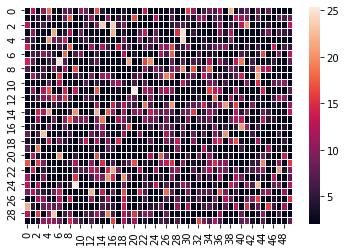

0


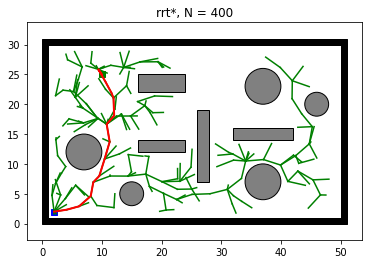

ERROR x pos:  0.0
ERROR x vel:  2.981580186205658
ERROR x acc:  -1.5495758585275419
ERROR y pos:  0.0
ERROR y vel:  -0.6840456075408934
ERROR y acc:  2.280667739961887
ERROR x pos:  -0.08364620437004722
ERROR x vel:  3.460437650038213
ERROR x acc:  1.4213327789867067
ERROR y pos:  -0.004026155835779033
ERROR y vel:  -1.0465689527320707
ERROR y acc:  -2.6716418832154
ERROR x pos:  -0.17312983320871167
ERROR x vel:  2.539685247641869
ERROR x acc:  -1.1551329984712044
ERROR y pos:  -0.011686944265208776
ERROR y vel:  0.4161081692518173
ERROR y acc:  8.998860711635265
ERROR x pos:  -0.2701213450582922
ERROR x vel:  4.170570562687203
ERROR x acc:  0.006434928423117547
ERROR y pos:  -0.04453250847848489
ERROR y vel:  -0.9372648948719842
ERROR y acc:  -7.5116089401076245
ERROR x pos:  -0.3352090021552001
ERROR x vel:  2.476004787756949
ERROR x acc:  -2.1974491358470902
ERROR y pos:  -0.0681797062803744
ERROR y vel:  -0.37787340563881355
ERROR y acc:  8.241175712979134
ERROR x pos:  -0.3039639

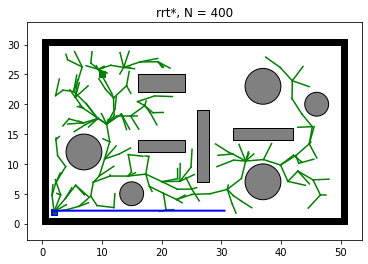

In [15]:
conf, command = rrt.planning()

In [17]:
rrt.c.y

array([ 2.04236735,  2.04236734,  2.04236732,  2.04236724,  2.0423671 ,
        2.04236687,  2.04236651,  2.04236602,  2.04236537,  2.04236454,
        2.04236349,  2.04236222,  2.04236069,  2.04235888,  2.04235677,
        2.04235434,  2.04235156,  2.04234841,  2.04234487,  2.04234091,
        2.04233652,  2.04233166,  2.04232632,  2.04232047,  2.04231408,
        2.04230715,  2.04229963,  2.04229152,  2.04228279,  2.0422734 ,
        2.04226335,  2.04225261,  2.04224116,  2.04222896,  2.04221601,
        2.04220228,  2.04218774,  2.04217237,  2.04215615,  2.04213906,
        2.04212108,  2.04210218,  2.04208234,  2.04206153,  2.04203975,
        2.04201695,  2.04199313,  2.04196826,  2.04194231,  2.04191527,
        2.04188712,  2.04185783,  2.04182737,  2.04179574,  2.04176291,
        2.04172885,  2.04169355,  2.04165698,  2.04161912,  2.04157996,
        2.04153947,  2.04149763,  2.04145443,  2.04140983,  2.04136382,
        2.04131638,  2.0412675 ,  2.04121714,  2.04116529,  2.04

## Splines

In [ ]:
path = rrt.tot_path
len(path)

In [ ]:
c = Controller(path, 100)

In [ ]:
discrete_steps = np.arange(0, 5, 1)
x_coords = [node[0].x for node in path]
y_coords = [node[0].y for node in path]

spl_x = UnivariateSpline(discrete_steps, x_coords, k=3)
spl_y = UnivariateSpline(discrete_steps, y_coords, k=3)

In [ ]:
conf, command = c.steer()

In [ ]:
command

In [ ]:
path = rrt.tot_path
x_coords = [node[0].x for node in path]
y_coords = [node[0].y for node in path]

time = np.arange(0, len(path), 1)


fx = UnivariateSpline(time, x_coords, k=3)
fy = UnivariateSpline(time, y_coords, k=3)

xnew = fx(time)
ynew = fy(time)

plt.plot(time, x_coords, 'o', time, xnew, '-')
plt.plot(time, y_coords, 'o', time, ynew, '-')

plt.show()

In [ ]:
len(path)

In [ ]:
fx(s(np.arange(0,50, 50/(25*10))))
fy(s(np.arange(0,50, 50/(25*10))))


In [ ]:
s = lambda t: ((t/50)**3)*25

fx(s(50))


In [ ]:
traj = []
for x,y in zip(xnew, ynew):
    traj.append((x,y))

traj = traj.reverse()

In [ ]:
def get_key(el):

    return el[0]

l = [(30, 1), (20, 2), (5, 4), (10,11)]
idx_min(l, key = get_key)


In [ ]:
rrt.rewire(N_near, n1, n_new)

In [ ]:
rrt.Tree[1].cost

In [ ]:
np.clip(np.random.normal(3, 1, size = (30, 50)), 0, 10)